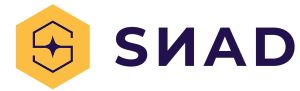

# AISSAI Anomaly detection workshop 2024: Adaptive Anomaly Detection Tutorial

This tutorial shows how to use the [coniferest](https://github.com/snad-space/coniferest) package, which was developed by the [SNAD team](https://snad.space/).
We show how to use it to build and run active anomaly discovery pipelines, both on a toy dataset and a dataset of astronomical objects.

Full documentation can be found at [ReadTheDocs](https://coniferest.readthedocs.io/en/latest/).


Developers of `conferest`:
- [Matwey Kornilov (MSU)](https://matwey.name)
- [Vladimir Korolev](https://www.linkedin.com/in/vladimir-korolev-a4195b86/)
- [Konstantin Malanchev (LINCC Frameworks / CMU)](https://homb.it), tutorial author

The tutorial is co-authored by [Emille Ishida (LPC)](https://www.emilleishida.com)

## Uncomment to install the dependencies

In [1]:
# !pip install -U coniferest

## Example: toy data

### Lets start by constructing some toy data

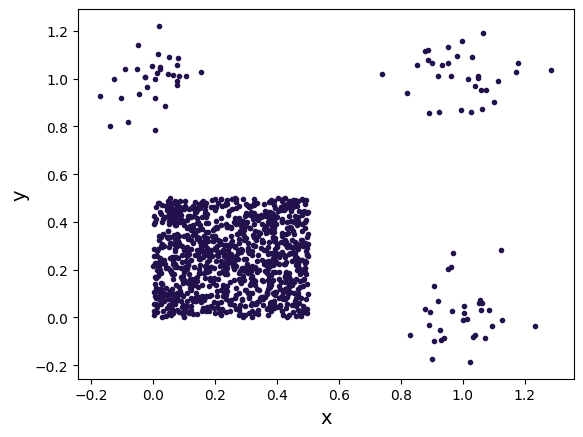

In [2]:
import matplotlib.pyplot as plt
from coniferest.datasets import non_anomalous_outliers
from coniferest.label import Label
import numpy as np

data_ex1, labels_ex1 = non_anomalous_outliers(
    # Number of regular objects
    inliers=1024,
    # Number of objects per each of three "outlier" classes
    outliers=32,
    # Classification of "outlier" classes
    regions=[Label.REGULAR, Label.REGULAR, Label.ANOMALY],
    seed=42
)

# Plot the data
plt.scatter(data_ex1[:,0], data_ex1[:,1], marker='.', color='#22114C')
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.show()

In [3]:
print(data_ex1.shape)
data_ex1

(1120, 2)


array([[ 0.38697802,  0.21943922],
       [ 0.42929896,  0.34868401],
       [ 0.04708867,  0.48781118],
       ...,
       [ 1.05489829,  0.07260984],
       [ 0.90689265, -0.09991449],
       [ 1.00368055,  0.01730071]])

### Non-active anomaly detection¶

Let’s run Isolation Forest model (see [Liu *et al.* 2008](https://doi.org/10.1109/ICDM.2008.17)) on the data we just created:

In [4]:
from coniferest.datasets import single_outlier
from coniferest.isoforest import IsolationForest

# declare and fit an isolation forest
model_iso = IsolationForest(random_seed=0)
model_iso.fit(data_ex1)

# evaluate classification
scores_iso = model_iso.score_samples(data_ex1)



---

The coniferest implementation of isolation forest is up to 100x faster than the scikit-learn one. See performance tests [here](https://coniferest.readthedocs.io/en/latest/isoforest.html).

---



#### Check the distribution of anomaly scores

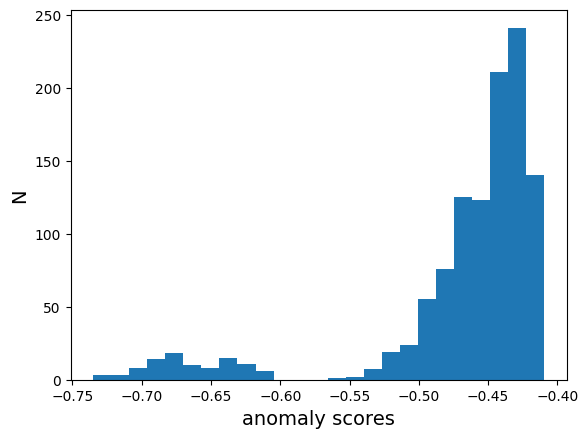

In [5]:
plt.figure()
plt.hist(scores_iso, bins=25)
plt.xlabel('anomaly scores', fontsize=14)
plt.ylabel('N', fontsize=14)
plt.show()

#### Define number of objects to investigate

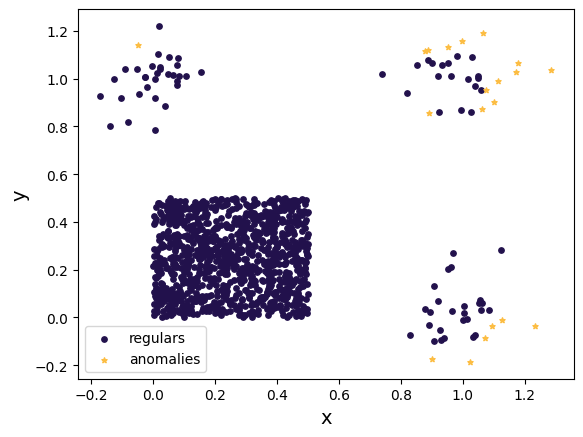

In [6]:
n = 20

indx = scores_iso.argsort()     # order objects according to their scores
anomalies = data_ex1[indx[:n]]  # separate anomalies
regulars = data_ex1[indx[n:]]   # separate regulars

plt.show()
plt.scatter(regulars[:,0], regulars[:,1], color='#22114C', marker='o',
            s=15, label='regulars')
plt.scatter(anomalies[:,0], anomalies[:,1], color='#FCBD43', marker='*',
            s=15, label='anomalies')
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.legend()
plt.show()

### Adaptive anomaly detection¶

#### Suppose you are interested in only 1 corner of the parameter space

We should define as metadata everything that can help us make a decision.

In our example, the information we need to know to make a decision is position.

In [7]:
# metadata should include info that will help you decide
metadata_ex1 = np.array(
    [f'ID = {i}, {x = :.2f}, {y = :.2f}' for i, (x,y) in enumerate(data_ex1)]
)
metadata_ex1

array(['ID = 0, x = 0.39, y = 0.22', 'ID = 1, x = 0.43, y = 0.35',
       'ID = 2, x = 0.05, y = 0.49', ..., 'ID = 1117, x = 1.05, y = 0.07',
       'ID = 1118, x = 0.91, y = -0.10', 'ID = 1119, x = 1.00, y = 0.02'],
      dtype='<U30')

#### Tune the anomaly algorithm to your definition of anomaly

In [8]:
from coniferest.pineforest import PineForest
from coniferest.session import Session
from coniferest.session.callback import (
    TerminateAfter, prompt_decision_callback,
)

# declare the model parameters
model_ex1 = PineForest(
    # Use 1024 trees, a trade-off between speed and accuracy
    n_trees=1024,
    # Fix random seed for reproducibility
    random_seed=None,
)

session_ex1 = Session(
    # Data to use
    data=data_ex1,
    # Metadata to help an expert (you!)
    metadata=metadata_ex1,
    model=model_ex1,
    # Ask expert interactively
    decision_callback=prompt_decision_callback,
    # Stop after `n` objects
    on_decision_callbacks=TerminateAfter(10),
)

session_ex1.run()

Is ID = 1049, x = 1.29, y = 1.04 anomaly? [y/N]:

  n


Is ID = 1043, x = 1.07, y = 1.19 anomaly? [y/N]:

  n


Is ID = 1073, x = -0.17, y = 0.93 anomaly? [y/N]:

  n


Is ID = 1113, x = 1.02, y = -0.19 anomaly? [y/N]:

  y


Is ID = 1114, x = 0.90, y = -0.17 anomaly? [y/N]:

  y


Is ID = 1118, x = 0.91, y = -0.10 anomaly? [y/N]:

  y


Is ID = 1095, x = 0.93, y = -0.09 anomaly? [y/N]:

  y


Is ID = 1107, x = 0.94, y = -0.09 anomaly? [y/N]:

  y


Is ID = 1098, x = 1.07, y = -0.08 anomaly? [y/N]:

  y


Is ID = 1089, x = 1.03, y = -0.08 anomaly? [y/N]:

  y


In [9]:
#  See targeted anomalies
session_ex1.known_anomalies

array([1113, 1114, 1118, 1095, 1107, 1098, 1089])

In [10]:
#  See targeted regulars
session_ex1.known_regulars

array([1049, 1043, 1073])

#### Plot your decisions

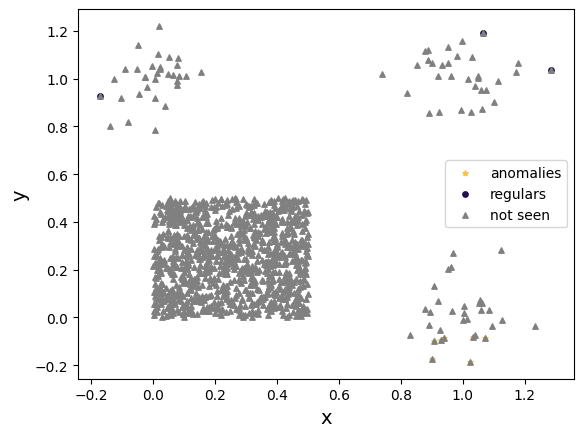

In [11]:
# Flag thins you did not see
flag_not_seen = ~np.isin(session_ex1.known_labels, data_ex1.shape[0])

plt.figure()
plt.scatter(*data_ex1[session_ex1.known_anomalies].T,
            color='#FCBD43', marker='*', s=15 ,label='anomalies')
plt.scatter(*data_ex1[session_ex1.known_regulars].T,
            color='#22114C', marker='o', s=15, label='regulars')
plt.scatter(*data_ex1[flag_not_seen].T,
            color='gray', marker='^', s=15, label='not seen')
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.legend()
plt.show()

### Semi-supervised

Suppose now that you have a set of labels you looked at yesterday...

In [12]:
data_ex2, labels_ex2 = non_anomalous_outliers(
    # Number of regular objects
    inliers=1024,
    #  Number of objects per each of three "outlier" classes
    outliers=32,
    # Classification of "outlier" classes
    regions=[Label.R, Label.R, Label.A],
    seed=None
)

labels_ex2

array([ 1,  1,  1, ..., -1, -1, -1])

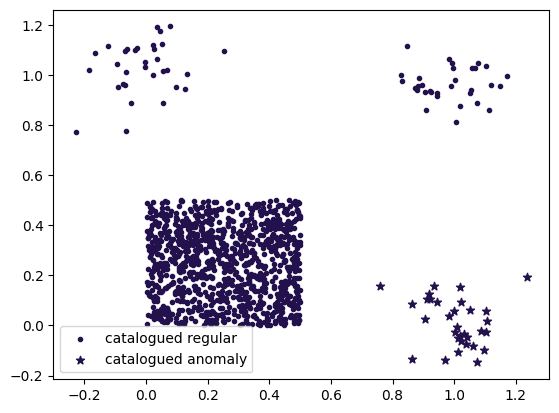

In [13]:
# Plot the data
index = labels_ex2 == Label.R
plt.scatter(*data_ex2[index, :].T, marker='.', color='#22114C',
            label='catalogued regular')
plt.scatter(*data_ex2[~index, :].T, marker='*', color='#22114C',
            label='catalogued anomaly')
plt.legend()
plt.show()

#### Create a session that will read your previous answer and train the model accordingly

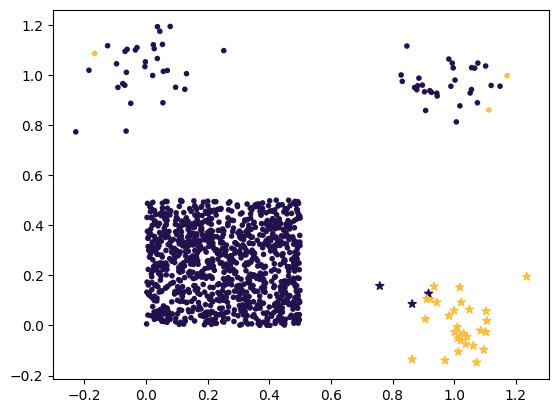

In [14]:
model_ex2 = PineForest(random_seed=None)

session_ex2 = Session(
    data_ex2,
    metadata=labels_ex2,
    model=model_ex2,
    # metadata consists of true labels, so we can use it as a decision
    decision_callback=lambda metadata, data, session: metadata,
    on_decision_callbacks=TerminateAfter(32),
)
session_ex2.run()

color = np.full_like(labels_ex2, '#22114C', dtype=object)
color[list(session_ex2.known_labels)] = '#FCBD43'

plt.cla()
plt.scatter(*data_ex2[index].T, marker='.', color=color[index],
            label='regular')
plt.scatter(*data_ex2[~index].T, marker='*', color=color[~index],
            label='anomaly')
plt.show()

#### Use the model for ex2 to estimate scores from ex1

In [15]:
scores_dex1_mex2 = session_ex2.model.score_samples(data_ex1)

In [16]:
data_ex2.shape

(1120, 2)

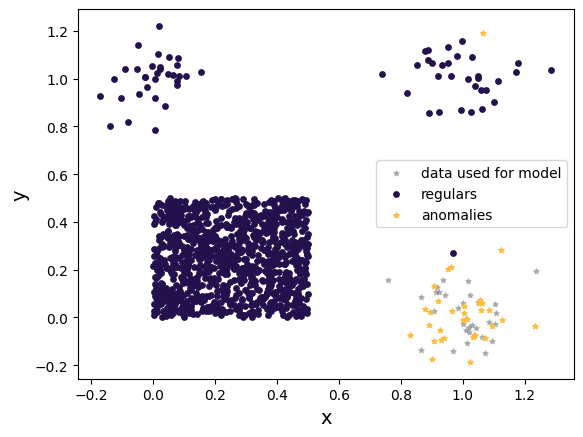

In [17]:
n_anomalies = 32

indx = scores_dex1_mex2.argsort()         # order objects according to their scores
anomalies = data_ex1[indx[:n_anomalies]]  # separate anomalies
regulars = data_ex1[indx[n_anomalies:]]   # separate regulars

plt.show()
plt.scatter(*data_ex2[~index].T, color='gray', label='data used for model',
            alpha=0.5,s=15, marker="*")
plt.scatter(*regulars.T, color='#22114C', marker='o', s=15,
            label='regulars')
plt.scatter(*anomalies.T, color='#FCBD43', marker='*', s=15,
            label='anomalies')
plt.xlabel('x', fontsize=14)
plt.ylabel('y', fontsize=14)
plt.legend()
plt.show()

## Example: ZTF light curves of M31 field¶

Let’s use built-in dataset of ZTF light curve features adopted from [Malanchev *et al.* (2021)](https://ui.adsabs.harvard.edu/abs/2021MNRAS.502.5147M/abstract):

In [18]:
from coniferest.datasets import ztf_m31

# import built-in data
data_ztf, metadata_ztf = ztf_m31()
print(data_ztf.shape)

(57546, 42)


Here data is 2-D feature dataset (lines are for objects, columns are for features) and metadata is 1-D array of ZTF DR object IDs.

In [19]:
data_ztf

array([[6.9950008e-01, 2.2794117e-01, 3.6764707e-02, ..., 2.0214492e-01,
        6.6418362e-01, 2.0516939e+01],
       [4.4299984e-01, 2.8888890e-01, 4.4444446e-02, ..., 1.6328827e-01,
        7.9298627e-01, 2.0698317e+01],
       [5.8949947e-01, 2.8000000e-01, 3.2000002e-02, ..., 1.9050223e-01,
        7.2875845e-01, 2.0749649e+01],
       ...,
       [7.3499680e-02, 2.7459016e-01, 4.9180329e-02, ..., 2.4325265e-02,
        7.9307187e-01, 1.7515738e+01],
       [4.3999672e-02, 3.1102362e-01, 7.4803151e-02, ..., 1.6327854e-02,
        7.9121703e-01, 1.5804447e+01],
       [1.9550037e-01, 2.2834645e-01, 5.5118110e-02, ..., 5.5768635e-02,
        7.1393239e-01, 1.8852880e+01]], dtype=float32)

In [20]:
metadata_ztf

array([695211400017839, 695211400043887, 695211400043454, ...,
       695211200027621, 695211200002462, 695211200070946], dtype=uint64)

Let's do anomaly detection!

In [21]:
from coniferest.pineforest import PineForest
from coniferest.session import Session
from coniferest.session.callback import (
    TerminateAfter, viewer_decision_callback,
)

model_ztf = PineForest(
    # Number of trees to use for predictions
    n_trees=256,
    # Number of new tree to grow for each decision
    n_spare_trees=768,
    # Fix random seed for reproducibility
    random_seed=0,
)

session_ztf = Session(
    data=data_ztf,
    metadata=metadata_ztf,
    model=model_ztf,
    # Prompt for a decision and open object's page on the SNAD Viewer
    decision_callback=viewer_decision_callback,
    on_decision_callbacks=[
        # Terminate session after 10 decisions
        TerminateAfter(10),
    ]
)
session_ztf.run()

Is 695211200075348 anomaly? [y/N]:

  n


Is 695211400053697 anomaly? [y/N]:

  n


Is 695211200035023 anomaly? [y/N]:

  n


Is 695211200020939 anomaly? [y/N]:

  n


Is 695211400132963 anomaly? [y/N]:

  n


Is 695211400011746 anomaly? [y/N]:

  y


Is 695211100020120 anomaly? [y/N]:

  n


Is 695211200019653 anomaly? [y/N]:

  y


Is 695211100037499 anomaly? [y/N]:

  y


Is 695211100024397 anomaly? [y/N]:

  y


## What is next?